# TensorFlow 那些事儿之DL中的 HELLO WORLD

- 基于MNIST数据集，运用TensorFlow中的 **tf.estimator** 中的 **tf.estimator.Estimator** 搭建一个简单的卷积神经网络，实现模型的训练，验证和测试

- TensorBoard的简单使用


## 导入各个库

In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import multiprocessing


from tensorflow import data
from tensorflow.python.feature_column import feature_column

tf.__version__

'1.8.0'

## MNIST数据集载入

### 看看MNIST数据长什么样子的

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

More info: http://yann.lecun.com/exdb/mnist/

- MNIST数据集包含70000张图像和对应的标签（图像的分类）。数据集被划为3个子集：训练集，验证集和测试集。

- 定义**MNIST**数据的基本信息

In [2]:
TRAIN_DATA_FILES_PATTERN = 'data_csv/mnist_train.csv'
VAL_DATA_FILES_PATTERN = 'data_csv/mnist_val.csv'
TEST_DATA_FILES_PATTERN = 'data_csv/mnist_test.csv'

MULTI_THREADING = True
RESUME_TRAINING = False

NUM_CLASS = 10
IMG_SHAPE = [28,28]

IMG_WIDTH = 28
IMG_HEIGHT = 28
IMG_FLAT = 784
NUM_CHANNEL = 1

BATCH_SIZE = 128
NUM_TRAIN = 55000
NUM_VAL = 5000
NUM_TEST = 10000

### 读取csv文件并查看数据信息

In [3]:
# train_data = pd.read_csv(TRAIN_DATA_FILES_PATTERN)
# train_data = pd.read_csv(TRAIN_DATA_FILES_PATTERN, header=None, names=HEADER )
train_data = pd.read_csv(TRAIN_DATA_FILES_PATTERN, header=None)
test_data = pd.read_csv(TEST_DATA_FILES_PATTERN, header=None)
val_data = pd.read_csv(VAL_DATA_FILES_PATTERN, header=None)

train_values = train_data.values
train_data = train_values[:,1:]/255.0
train_label = train_values[:,0:1].squeeze()

val_values = val_data.values
val_data = val_values[:,1:]/255.0
val_label = val_values[:,0:1].squeeze()

test_values = test_data.values
test_data = test_values[:,1:]/255.0
test_label = test_values[:,0:1].squeeze()

print('test_data',np.shape(test_data))
print('test_label',np.shape(test_label))

print('val_data',np.shape(val_data))
print('val_label',np.shape(val_label))

print('train_data',np.shape(train_data))
print('train_label',np.shape(train_label))

# train_data.head(10)
# test_data.head(10)

test_data (10000, 784)
test_label (10000,)
val_data (5000, 784)
val_label (5000,)
train_data (55000, 784)
train_label (55000,)


## 试试自己写一个estimator

- 基于**MNIST数据集**，运用TensorFlow中的 **tf.estimator** 中的 **tf.estimator.Estimator** 搭建一个简单的卷积神经网络，实现模型的训练，验证和测试

- [官网API](https://tensorflow.google.cn/api_docs/python/tf/estimator/Estimator)

- 看看有哪些参数

```python
__init__(
    model_fn,
    model_dir=None,
    config=None,
    params=None,
    warm_start_from=None
)
```
- 本例中，重点在 **tf.estimator.Estimator** 中的 `model_fn`


### 先简单看看数据流

下面的图表直接显示了本次MNIST例子的数据流向，共有**2个卷积层**，每一层卷积之后采用最大池化进行下采样（图中并未画出），最后接**2个全连接层**，实现对MNIST数据集的分类

![Flowchart](images/02_network_flowchart.png)

### 先看看input_fn之创建输入函数

In [5]:
batch_size = BATCH_SIZE

# Define the input function for training
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'images': np.array(train_data)},
    y = np.array(train_label),
    batch_size=batch_size,
    num_epochs=None, 
    shuffle=True)

In [6]:
# Evaluate the Model
# Define the input function for evaluating
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'images': np.array(test_data)},
    y = np.array(test_label),
    batch_size=batch_size, 
    shuffle=False)

In [7]:
# Predict some images
some_images = test_data[0:9]
print('some images',np.shape(some_images))

# Define the input function for predicting
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': some_images},
    num_epochs=1,
    shuffle=False)

some images (9, 784)


### 定义feature_columns

In [10]:
feature_x = tf.feature_column.numeric_column('images', shape=IMG_SHAPE)

feature_columns = [feature_x]

### 重点在这里——model_fn


#### model_fn: Model function. Follows the signature:

* Args:
  * `features`: This is the first item returned from the `input_fn` passed to `train`, `evaluate`, and `predict`. This should be a single `tf.Tensor` or `dict` of same.
  * `labels`: This is the second item returned from the `input_fn` passed to `train`, `evaluate`, and `predict`. This should be a single `tf.Tensor` or `dict` of same (for multi-head models).If mode is @{tf.estimator.ModeKeys.PREDICT}, `labels=None` will be passed. If the `model_fn`'s signature does not accept `mode`, the `model_fn` must still be able to handle `labels=None`.
  * `mode`: Optional. Specifies if this training, evaluation or prediction. See `tf.estimator.ModeKeys`.
  * `params`: Optional `dict` of hyperparameters.  Will receive what is passed to Estimator in `params` parameter. This allows to configure Estimators from hyper parameter tuning.
  * `config`: Optional `estimator.RunConfig` object. Will receive what is passed to Estimator as its `config` parameter, or a default value. Allows setting up things in your `model_fn` based on configuration such as `num_ps_replicas`, or `model_dir`.
* Returns:
    `tf.estimator.EstimatorSpec`
    
#### 注意model_fn返回的tf.estimator.EstimatorSpec
<img style="float: left;" src="images/0_TF_HELLO.png" width="60%">




### 定义我们自己的model_fn

In [19]:
def model_fn(features, labels, mode, params):
    # Args:
    #
    # features: This is the x-arg from the input_fn.
    # labels:   This is the y-arg from the input_fn,
    #           see e.g. train_input_fn for these two.
    # mode:     Either TRAIN, EVAL, or PREDICT
    # params:   User-defined hyper-parameters, e.g. learning-rate.
    
    # Reference to the tensor named "x" in the input-function.
#     x = features["images"]
    x = tf.feature_column.input_layer(features, params['feature_columns'])
    # The convolutional layers expect 4-rank tensors
    # but x is a 2-rank tensor, so reshape it.
    net = tf.reshape(x, [-1, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNEL])    

    # First convolutional layer.
    net = tf.layers.conv2d(inputs=net, name='layer_conv1',
                           filters=16, kernel_size=5,
                           padding='same', activation=tf.nn.relu)
    net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)

    # Second convolutional layer.
    net = tf.layers.conv2d(inputs=net, name='layer_conv2',
                           filters=36, kernel_size=5,
                           padding='same', activation=tf.nn.relu)
    net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)    

    # Flatten to a 2-rank tensor.
    net = tf.contrib.layers.flatten(net)
    # Eventually this should be replaced with:
    # net = tf.layers.flatten(net)

    # First fully-connected / dense layer.
    # This uses the ReLU activation function.
    net = tf.layers.dense(inputs=net, name='layer_fc1',
                          units=128, activation=tf.nn.relu)    

    # Second fully-connected / dense layer.
    # This is the last layer so it does not use an activation function.
    net = tf.layers.dense(inputs=net, name='layer_fc2',
                          units=10)

    # Logits output of the neural network.
    logits = net

    # Softmax output of the neural network.
    y_pred = tf.nn.softmax(logits=logits)
    
    # Classification output of the neural network.
    y_pred_cls = tf.argmax(y_pred, axis=1)

    if mode == tf.estimator.ModeKeys.PREDICT:
        # If the estimator is supposed to be in prediction-mode
        # then use the predicted class-number that is output by
        # the neural network. Optimization etc. is not needed.
        spec = tf.estimator.EstimatorSpec(mode=mode,
                                          predictions=y_pred_cls)
    else:
        # Otherwise the estimator is supposed to be in either
        # training or evaluation-mode. Note that the loss-function
        # is also required in Evaluation mode.
        
        # Define the loss-function to be optimized, by first
        # calculating the cross-entropy between the output of
        # the neural network and the true labels for the input data.
        # This gives the cross-entropy for each image in the batch.
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels,
                                                                       logits=logits)

        # Reduce the cross-entropy batch-tensor to a single number
        # which can be used in optimization of the neural network.
        loss = tf.reduce_mean(cross_entropy)

        # Define the optimizer for improving the neural network.
        optimizer = tf.train.AdamOptimizer(learning_rate=params["learning_rate"])

        # Get the TensorFlow op for doing a single optimization step.
        train_op = optimizer.minimize(
            loss=loss, global_step=tf.train.get_global_step())

        # Define the evaluation metrics,
        # in this case the classification accuracy.
        metrics = \
        {
            "accuracy": tf.metrics.accuracy(labels, y_pred_cls)
        }

        # Wrap all of this in an EstimatorSpec.
        spec = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss,
            train_op=train_op,
            eval_metric_ops=metrics)
        
    return spec

### 自建的estimator在这里

我们可以指定超参数，例如优化器的学习率。

In [23]:
params = {"learning_rate": 1e-4,
         'feature_columns': feature_columns}

In [24]:
model = tf.estimator.Estimator(model_fn=model_fn,
                               params=params,
                               model_dir="./cnn_classifer/")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_evaluation_master': '', '_session_config': None, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_master': '', '_is_chief': True, '_task_type': 'worker', '_keep_checkpoint_max': 5, '_service': None, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x138630d68>, '_model_dir': './cnn_classifer/', '_task_id': 0, '_num_worker_replicas': 1, '_num_ps_replicas': 0, '_save_checkpoints_steps': None, '_global_id_in_cluster': 0, '_train_distribute': None, '_keep_checkpoint_every_n_hours': 10000, '_save_summary_steps': 100}


### 训练训练看看

In [26]:
model.train(input_fn=train_input_fn, steps=2000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ./cnn_classifer/model.ckpt.
INFO:tensorflow:step = 1, loss = 2.3124514
INFO:tensorflow:global_step/sec: 5.13683
INFO:tensorflow:step = 101, loss = 1.004812 (19.469 sec)
INFO:tensorflow:global_step/sec: 4.44593
INFO:tensorflow:step = 201, loss = 0.40566427 (22.492 sec)
INFO:tensorflow:global_step/sec: 5.59063
INFO:tensorflow:step = 301, loss = 0.28785554 (17.887 sec)
INFO:tensorflow:global_step/sec: 5.88434
INFO:tensorflow:step = 401, loss = 0.23790869 (16.994 sec)
INFO:tensorflow:global_step/sec: 5.28758
INFO:tensorflow:step = 501, loss = 0.2865603 (18.912 sec)
INFO:tensorflow:global_step/sec: 5.55467
INFO:tensorflow:step = 601, loss = 0.27893203 (18.004 sec)
INFO:tensorflow:global_step/sec: 5.46903
INFO:ten

In [27]:
# Use the Estimator 'evaluate' method
model.evaluate(eval_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-10-25-04:44:07
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./cnn_classifer/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-25-04:44:14
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9761, global_step = 2000, loss = 0.07788641


{'accuracy': 0.9761, 'global_step': 2000, 'loss': 0.07788641}

### 测试一下瞅瞅

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./cnn_classifer/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


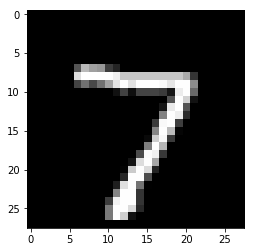

Model prediction: 7


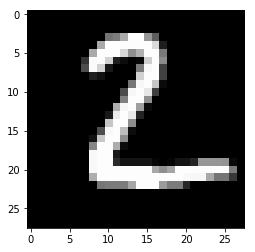

Model prediction: 2


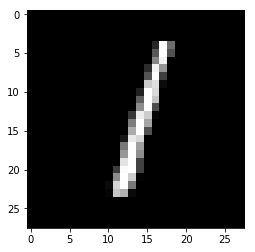

Model prediction: 1


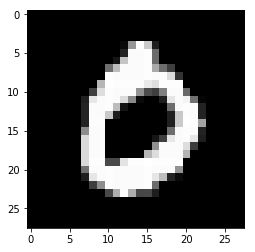

Model prediction: 0


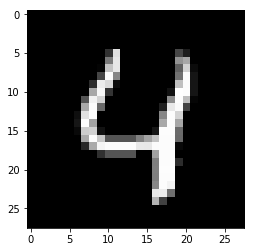

Model prediction: 4


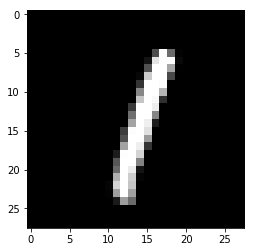

Model prediction: 1


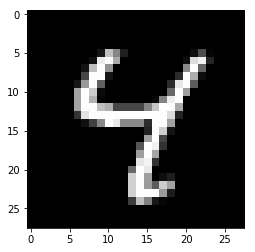

Model prediction: 4


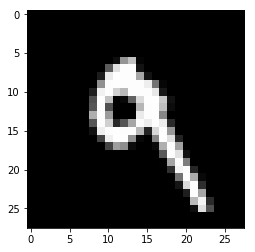

Model prediction: 9


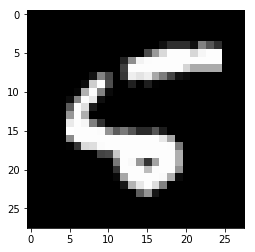

Model prediction: 5


In [28]:
# Use the model to predict the images class
preds = list(model.predict(test_input_fn))

n_images = 9
# Display
for i in range(n_images):
    plt.imshow(np.reshape(some_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction:", preds[i])